# 로이터 뉴스 분류 - Word2Vec 임베딩 활용

이 노트북에서는 로이터 뉴스 데이터셋을 사용하여 텍스트 분류 모델을 구축합니다.
사전 훈련된 Word2Vec 임베딩을 활용하여 성능을 향상시키는 방법을 학습합니다.

## 목차
1. [환경 설정 및 라이브러리 임포트](#1-환경-설정-및-라이브러리-임포트)
2. [데이터셋 구성](#2-데이터셋-구성)
3. [데이터 로딩 및 전처리](#3-데이터-로딩-및-전처리)
4. [Word2Vec 임베딩 설정](#4-word2vec-임베딩-설정)
5. [모델 구축 및 훈련](#5-모델-구축-및-훈련)
6. [결과 평가](#6-결과-평가)

## 1. 환경 설정 및 라이브러리 임포트

### 필수 설치 사항
- **중요**: KoNLPy와 Korpora는 pip로 설치해야 합니다
- Gensim: Word2Vec 모델 로딩을 위해 필요

```bash
pip install konlpy korpora gensim
```

In [2]:
# 핵심 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization

# 자연어 처리
from konlpy.tag import Okt
from gensim.models import KeyedVectors

# 기본 라이브러리
import os
import pathlib
import shutil
import random
import re
import string
import subprocess
import requests

# 데이터 처리 및 분석
import numpy as np
import pandas as pd

print(f"TensorFlow 버전: {tf.__version__}")

TensorFlow 버전: 2.15.1


## 2. 데이터셋 구성

로이터 뉴스 데이터를 디렉토리 구조로 정리하는 함수입니다.
각 카테고리별로 폴더를 생성하고 텍스트 파일을 저장합니다.

In [3]:
def create_dataset(base_dir="../../data/reuter"):
    """
    로이터 뉴스 데이터를 디렉토리 구조로 정리
    
    Args:
        base_dir (str): 데이터를 저장할 기본 디렉토리명
    
    Returns:
        None
    """
    # 기존 디렉토리가 있으면 삭제
    if os.path.exists(base_dir):
        try:
            shutil.rmtree(base_dir)
            print(f"기존 데이터셋 디렉토리 삭제: {base_dir}")
        except OSError as e:
            print(f"디렉토리 삭제 오류 {base_dir}: {e}")
            pass

    file_count = 0
    
    # 훈련 데이터 처리
    print("훈련 데이터 처리 중...")
    try:
        with open("../../data/r8-train-all-terms.txt", "r", encoding="utf-8") as f:
            for line in f:
                if '\t' in line:
                    label, sentence = line.strip().split("\t", 1)
                    file_count += 1
                    
                    # 레이블별 디렉토리 생성
                    label_dir = os.path.join(base_dir, label)
                    os.makedirs(label_dir, exist_ok=True)
                    
                    # 파일 저장
                    with open(os.path.join(label_dir, f"{label}_{file_count}.txt"), 
                             "w", encoding="utf-8") as output_file:
                        output_file.write(sentence)
                    
                    if file_count % 1000 == 0:
                        print(f"처리된 파일 수: {file_count}")
    except FileNotFoundError:
        print("훈련 데이터 파일을 찾을 수 없습니다: ../../data/r8-train-all-terms.txt")
        return
    
    # 테스트 데이터 처리
    print("테스트 데이터 처리 중...")
    try:
        with open("../../data/r8-test-all-terms.txt", "r", encoding="utf-8") as f:
            for line in f:
                if '\t' in line:
                    label, sentence = line.strip().split("\t", 1)
                    file_count += 1
                    
                    # 레이블별 디렉토리 생성
                    label_dir = os.path.join(base_dir, label)
                    os.makedirs(label_dir, exist_ok=True)
                    
                    # 파일 저장
                    with open(os.path.join(label_dir, f"{label}_{file_count}.txt"), 
                             "w", encoding="utf-8") as output_file:
                        output_file.write(sentence)
                        
                    if file_count % 1000 == 0:
                        print(f"처리된 파일 수: {file_count}")
    except FileNotFoundError:
        print("테스트 데이터 파일을 찾을 수 없습니다: ../../data/r8-test-all-terms.txt")
        return
    
    print(f"데이터셋 구성 완료: 총 {file_count}개 파일 생성")

# 데이터셋 생성 (필요시 주석 해제)
create_dataset()

훈련 데이터 처리 중...
처리된 파일 수: 1000
처리된 파일 수: 2000
처리된 파일 수: 3000
처리된 파일 수: 4000
처리된 파일 수: 5000
테스트 데이터 처리 중...
처리된 파일 수: 6000
처리된 파일 수: 7000
데이터셋 구성 완료: 총 7674개 파일 생성


### 데이터셋 정보 확인

In [4]:
def load_file_info(base_dir="../../data/reuter"):
    """
    데이터셋의 구조와 각 카테고리별 파일 수를 확인
    
    Args:
        base_dir (str): 데이터가 저장된 디렉토리명
    """
    if not os.path.exists(base_dir):
        print(f"디렉토리 '{base_dir}'가 존재하지 않습니다.")
        print("먼저 create_dataset() 함수를 실행해주세요.")
        return
    
    labelnames = os.listdir(base_dir)
    print("=== 로이터 뉴스 데이터셋 정보 ===")
    print(f"카테고리 목록: {labelnames}")
    print("\n카테고리별 파일 수:")
    
    total_cnt = 0
    category_info = []
    
    for label in labelnames:
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            cnt = len(os.listdir(label_path))
            total_cnt += cnt
            category_info.append((label, cnt))
            print(f"  {label}: {cnt:,}개")
    
    print(f"\n전체 파일 수: {total_cnt:,}개")
    print(f"카테고리 수: {len(labelnames)}개")
    
    return category_info

# 데이터셋 정보 확인
dataset_info = load_file_info()

=== 로이터 뉴스 데이터셋 정보 ===
카테고리 목록: ['acq', 'crude', 'earn', 'grain', 'interest', 'money-fx', 'ship', 'trade']

카테고리별 파일 수:
  acq: 2,292개
  crude: 374개
  earn: 3,923개
  grain: 51개
  interest: 271개
  money-fx: 293개
  ship: 144개
  trade: 326개

전체 파일 수: 7,674개
카테고리 수: 8개


### 예상 데이터셋 구성
```
acq: 2,292개        # 인수합병
crude: 374개        # 원유
earn: 3,923개       # 수익
grain: 51개         # �곡물
interest: 271개     # 금리
money-fx: 293개     # 환율
ship: 144개         # 운송
trade: 326개        # 무역
전체: 7,674개
```

## 3. 데이터 로딩 및 전처리

TensorFlow의 `text_dataset_from_directory`를 사용하여 데이터를 로딩하고,
텍스트 벡터화를 위한 전처리를 수행합니다.

In [5]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
MAX_TOKENS = 20000
SEQUENCE_LENGTH = 600

print("=== 데이터 로딩 설정 ===")
print(f"배치 크기: {BATCH_SIZE}")
print(f"최대 토큰 수: {MAX_TOKENS:,}")
print(f"시퀀스 길이: {SEQUENCE_LENGTH}")

=== 데이터 로딩 설정 ===
배치 크기: 32
최대 토큰 수: 20,000
시퀀스 길이: 600


In [6]:
# 데이터셋 로딩
try:
    train_ds = keras.utils.text_dataset_from_directory(
        "../../data/reuter", 
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="training",
        seed=42
    )
    
    val_ds = keras.utils.text_dataset_from_directory(
        "../../data/reuter", 
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="validation",
        seed=42
    )
    
    print("데이터셋 로딩 성공")
    print(f"클래스 이름: {train_ds.class_names}")
    
except Exception as e:
    print(f"데이터셋 로딩 실패: {e}")
    print("먼저 create_dataset() 함수를 실행해주세요.")

Found 7674 files belonging to 8 classes.
Using 6140 files for training.
Found 7674 files belonging to 8 classes.
Using 1534 files for validation.
데이터셋 로딩 성공
클래스 이름: ['acq', 'crude', 'earn', 'grain', 'interest', 'money-fx', 'ship', 'trade']


In [7]:
# 텍스트만 추출 (라벨 제외)
text_only_train_ds = train_ds.map(lambda x, y: x)

# 데이터 샘플 확인
print("=== 데이터 샘플 확인 ===")
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):  # 처음 3개 샘플만 확인
        print(f"\n샘플 {i+1}:")
        print(f"레이블: {train_ds.class_names[label_batch[i]]}")
        print(f"텍스트 (처음 100자): {text_batch[i].numpy().decode('utf-8')[:100]}...")

=== 데이터 샘플 확인 ===

샘플 1:
레이블: earn
텍스트 (처음 100자): bank of new england bkne o post pro forma net bank of new england corp reported that pro forma first...

샘플 2:
레이블: acq
텍스트 (처음 100자): bramall to acquire gelco for up to mln dlrs c d bramall plc said in a statement accompanying its ann...

샘플 3:
레이블: interest
텍스트 (처음 100자): toronto dominion bank cuts prime rate to pct from pct tomorrow...


### 텍스트 벡터화 설정

In [9]:
# 텍스트 벡터화 레이어 생성
text_vectorization = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

# 텍스트 데이터에 맞춰 벡터화 레이어 적응
print("텍스트 벡터화 레이어 적응 중...")
text_vectorization.adapt(text_only_train_ds)

# 어휘 사전 생성
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

print(f"어휘 사전 크기: {len(vocabulary):,}개")
print(f"상위 10개 단어: {vocabulary[:10]}")

텍스트 벡터화 레이어 적응 중...
어휘 사전 크기: 20,000개
상위 10개 단어: ['', '[UNK]', 'the', 'of', 'to', 'in', 'said', 'a', 'and', 'mln']


In [10]:
# 훈련 데이터를 정수 시퀀스로 변환
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# 성능 최적화를 위한 데이터셋 설정
int_train_ds = int_train_ds.cache().prefetch(tf.data.AUTOTUNE)
int_val_ds = int_val_ds.cache().prefetch(tf.data.AUTOTUNE)

print("데이터 전처리 완료")

데이터 전처리 완료


## 4. Word2Vec 임베딩 설정

사전 훈련된 Word2Vec 모델을 로딩하고 임베딩 행렬을 생성합니다.

### Word2Vec 모델 다운로드
Google News Vector: https://code.google.com/archive/p/word2vec/
FastText 벡터: https://fasttext.cc/docs/en/crawl-vectors.html

In [11]:
# Word2Vec 모델 파일 경로 (실제 경로로 수정 필요)
PATH_TO_WORD2VEC_FILE = "../../data/GoogleNews-vectors-negative300.bin"

print("=== Word2Vec 모델 로딩 ===")
print(f"모델 파일 경로: {PATH_TO_WORD2VEC_FILE}")

# Word2Vec 모델 로딩
try:
    word2vec_model = KeyedVectors.load_word2vec_format(
        PATH_TO_WORD2VEC_FILE, 
        binary=True,
        limit=500000  # 메모리 사용량 제한
    )
    print(f"Word2Vec 모델 로딩 성공")
    print(f"벡터 차원: {word2vec_model.vector_size}")
    print(f"어휘 사전 크기: {len(word2vec_model.key_to_index):,}개")
    
    embedding_dim = word2vec_model.vector_size
    
except FileNotFoundError:
    print("❌ Word2Vec 모델 파일을 찾을 수 없습니다.")
    print("다음 중 하나를 다운로드하세요:")
    print("1. GoogleNews-vectors-negative300.bin.gz (구글 검색)")
    print("2. 압축 해제 후 경로를 올바르게 설정")
    
    # 대안: 랜덤 임베딩 사용
    print("\n대안으로 랜덤 임베딩을 사용합니다.")
    embedding_dim = 300
    word2vec_model = None
    
except Exception as e:
    print(f"❌ Word2Vec 모델 로딩 오류: {e}")
    embedding_dim = 300
    word2vec_model = None

=== Word2Vec 모델 로딩 ===
모델 파일 경로: ../../data/GoogleNews-vectors-negative300.bin
Word2Vec 모델 로딩 성공
벡터 차원: 300
어휘 사전 크기: 500,000개


### 임베딩 행렬 생성

In [12]:
# 임베딩 행렬 초기화
embedding_matrix = np.zeros((MAX_TOKENS, embedding_dim))

if word2vec_model is not None:
    print("\n=== 임베딩 행렬 생성 ===")
    print("Word2Vec 벡터로 임베딩 행렬 채우는 중...")
    
    hits = 0
    misses = 0
    
    for word, i in word_index.items():
        if i < MAX_TOKENS:
            try:
                # Word2Vec에서 벡터 가져오기
                embedding_vector = word2vec_model[word]
                embedding_matrix[i] = embedding_vector
                hits += 1
            except KeyError:
                # 단어가 Word2Vec 어휘에 없는 경우
                misses += 1
                # 랜덤 벡터로 초기화 (선택사항)
                embedding_matrix[i] = np.random.normal(
                    scale=0.1, size=(embedding_dim,)
                )
    
    print(f"✅ 임베딩 벡터 적용: {hits:,}개 단어")
    print(f"❌ 누락된 단어: {misses:,}개")
    print(f"📊 적용률: {hits/(hits+misses)*100:.1f}%")
    
else:
    print("\n=== 랜덤 임베딩 행렬 생성 ===")
    # Word2Vec 모델이 없는 경우 랜덤 초기화
    embedding_matrix = np.random.normal(
        scale=0.1, size=(MAX_TOKENS, embedding_dim)
    )
    print(f"랜덤 임베딩 행렬 생성 완료: {embedding_matrix.shape}")


=== 임베딩 행렬 생성 ===
Word2Vec 벡터로 임베딩 행렬 채우는 중...
✅ 임베딩 벡터 적용: 11,877개 단어
❌ 누락된 단어: 8,123개
📊 적용률: 59.4%


### 임베딩 레이어 생성

In [13]:
# 임베딩 레이어 생성
embedding_layer = layers.Embedding(
    input_dim=MAX_TOKENS,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # 사전 훈련된 임베딩 고정
    mask_zero=True,   # 패딩 토큰 마스킹
    name="embedding_layer"
)

print(f"임베딩 레이어 생성 완료")
print(f"  - 입력 차원: {MAX_TOKENS:,}")
print(f"  - 출력 차원: {embedding_dim}")
print(f"  - 훈련 가능: {embedding_layer.trainable}")
print(f"  - 마스킹: {embedding_layer.mask_zero}")

임베딩 레이어 생성 완료
  - 입력 차원: 20,000
  - 출력 차원: 300
  - 훈련 가능: False
  - 마스킹: True


## 5. 모델 구축 및 훈련

Bidirectional LSTM을 사용한 텍스트 분류 모델을 구축합니다.

In [14]:
# 모델 구축
def build_model(num_classes):
    """
    Word2Vec 임베딩을 사용한 텍스트 분류 모델 구축
    
    Args:
        num_classes (int): 분류할 클래스 수
    
    Returns:
        keras.Model: 컴파일된 모델
    """
    inputs = keras.Input(shape=(None,), dtype="int64", name="text_input")
    
    # 임베딩 레이어
    embedded = embedding_layer(inputs)
    
    # Bidirectional LSTM
    x = layers.Bidirectional(
        layers.LSTM(32, return_sequences=False),
        name="bidirectional_lstm"
    )(embedded)
    
    # 드롭아웃 정규화
    x = layers.Dropout(0.5, name="dropout")(x)
    
    # 출력 레이어
    outputs = layers.Dense(
        num_classes, 
        activation="softmax", 
        name="classification_output"
    )(x)
    
    model = keras.Model(inputs, outputs, name="reuters_classifier")
    
    # 모델 컴파일
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# 클래스 수 확인
num_classes = len(train_ds.class_names)
print(f"분류할 클래스 수: {num_classes}개")
print(f"클래스 목록: {train_ds.class_names}")

# 모델 생성
model = build_model(num_classes)
model.summary()

분류할 클래스 수: 8개
클래스 목록: ['acq', 'crude', 'earn', 'grain', 'interest', 'money-fx', 'ship', 'trade']

Model: "reuters_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, None)]            0         
                                                                 
 embedding_layer (Embedding  (None, None, 300)         6000000   
 )                                                               
                                                                 
 bidirectional_lstm (Bidire  (None, 64)                85248     
 ctional)                                                        
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 classification_output (Den  (None, 8)                 520       
 se)            

### 훈련 설정 및 실행

In [15]:
# 훈련 설정
EPOCHS = 10
MODEL_CHECKPOINT_PATH = "word2vec_embeddings_sequence_model.keras"

# 콜백 설정
callbacks = [
    keras.callbacks.ModelCheckpoint(
        MODEL_CHECKPOINT_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )
]

print("=== 모델 훈련 시작 ===")
print(f"에포크 수: {EPOCHS}")
print(f"모델 저장 경로: {MODEL_CHECKPOINT_PATH}")
print(f"사용 임베딩: {'Word2Vec' if word2vec_model else '랜덤 초기화'}")

=== 모델 훈련 시작 ===
에포크 수: 10
모델 저장 경로: word2vec_embeddings_sequence_model.keras
사용 임베딩: Word2Vec


In [17]:
# 모델 훈련
history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ 모델 훈련 완료")

Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.7927
Epoch 1: val_accuracy improved from -inf to 0.89765, saving model to word2vec_embeddings_sequence_model.keras
192/192 [==============================] - 91s 454ms/step - loss: 0.6339 - accuracy: 0.7927 - val_loss: 0.3598 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8953
Epoch 2: val_accuracy improved from 0.89765 to 0.93937, saving model to word2vec_embeddings_sequence_model.keras
192/192 [==============================] - 89s 463ms/step - loss: 0.3407 - accuracy: 0.8953 - val_loss: 0.2316 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9321
Epoch 3: val_accuracy improved from 0.93937 to 0.95372, saving model to word2vec_embeddings_sequence_model.keras
192/192 [==============================] - 89s 462ms/step - loss: 0.2340 - accurac

## 6. 결과 평가

훈련된 모델의 성능을 평가하고 결과를 시각화합니다.

In [18]:
# 최고 성능 모델 로딩
print("=== 모델 평가 ===")
try:
    best_model = keras.models.load_model(MODEL_CHECKPOINT_PATH)
    print(f"최고 성능 모델 로딩 완료: {MODEL_CHECKPOINT_PATH}")
except:
    best_model = model
    print("저장된 모델을 찾을 수 없어 현재 모델을 사용합니다.")

# 검증 데이터로 평가
val_loss, val_accuracy = best_model.evaluate(int_val_ds, verbose=0)
print(f"\n📊 최종 성능:")
print(f"  - 검증 손실: {val_loss:.4f}")
print(f"  - 검증 정확도: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

=== 모델 평가 ===
최고 성능 모델 로딩 완료: word2vec_embeddings_sequence_model.keras

📊 최종 성능:
  - 검증 손실: 0.1131
  - 검증 정확도: 0.9687 (96.87%)


### 훈련 과정 시각화

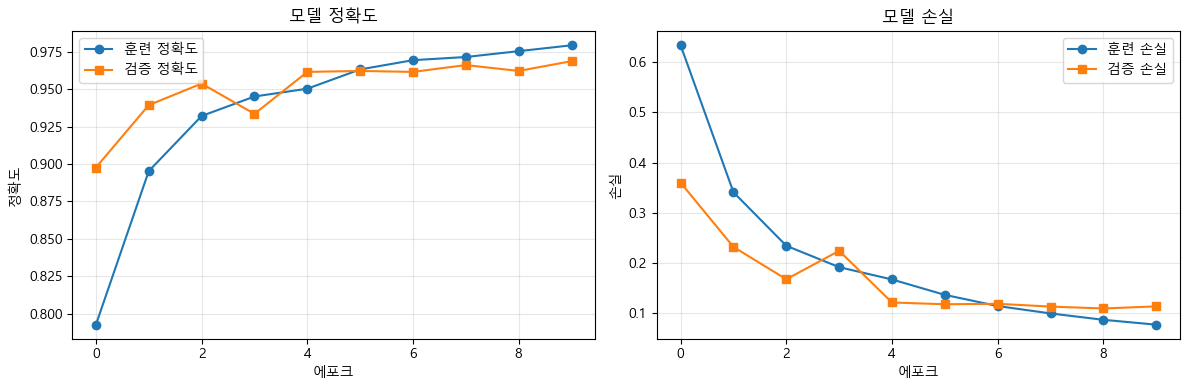


🏆 최고 성능:
  - 에포크: 10
  - 검증 정확도: 0.9687 (96.87%)


In [21]:
import matplotlib.pyplot as plt

# 훈련 히스토리 시각화
def plot_training_history(history):
    """
    훈련 과정을 시각화
    
    Args:
        history: 훈련 히스토리 객체
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 한글 폰트 설정
    plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 정확도 그래프
    ax1.plot(history.history['accuracy'], label='훈련 정확도', marker='o')
    ax1.plot(history.history['val_accuracy'], label='검증 정확도', marker='s')
    ax1.set_title('모델 정확도')
    ax1.set_xlabel('에포크')
    ax1.set_ylabel('정확도')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 손실 그래프
    ax2.plot(history.history['loss'], label='훈련 손실', marker='o')
    ax2.plot(history.history['val_loss'], label='검증 손실', marker='s')
    ax2.set_title('모델 손실')
    ax2.set_xlabel('에포크')
    ax2.set_ylabel('손실')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 최고 성능 정보
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    print(f"\n🏆 최고 성능:")
    print(f"  - 에포크: {best_epoch + 1}")
    print(f"  - 검증 정확도: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

# 훈련 과정 시각화
plot_training_history(history)

### 예측 예시

In [22]:
# 예측 함수
def predict_news_category(text, model, vectorizer, class_names):
    """
    텍스트의 뉴스 카테고리를 예측
    
    Args:
        text (str): 예측할 텍스트
        model: 훈련된 모델
        vectorizer: 텍스트 벡터화 레이어
        class_names: 클래스 이름 목록
    
    Returns:
        tuple: (예측 카테고리, 신뢰도, 모든 확률)
    """
    # 텍스트 전처리 및 벡터화
    text_vector = vectorizer([text])
    
    # 예측
    predictions = model.predict(text_vector, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    return class_names[predicted_class_idx], confidence, predictions[0]

# 테스트 예시
test_texts = [
    "The company reported strong quarterly earnings with revenue up 15%",
    "Oil prices rose sharply following geopolitical tensions in the Middle East",
    "The Federal Reserve announced an interest rate hike of 0.25%",
    "Wheat futures declined due to favorable weather conditions"
]

print("=== 예측 결과 ===")
for i, text in enumerate(test_texts, 1):
    category, confidence, all_probs = predict_news_category(
        text, best_model, text_vectorization, train_ds.class_names
    )
    
    print(f"\n{i}. 텍스트: {text[:60]}...")
    print(f"   예측 카테고리: {category}")
    print(f"   신뢰도: {confidence:.3f} ({confidence*100:.1f}%)")
    
    # 상위 3개 확률 표시
    top3_idx = np.argsort(all_probs)[-3:][::-1]
    print(f"   상위 3개 확률:")
    for idx in top3_idx:
        print(f"     {train_ds.class_names[idx]}: {all_probs[idx]:.3f}")

=== 예측 결과 ===

1. 텍스트: The company reported strong quarterly earnings with revenue ...
   예측 카테고리: earn
   신뢰도: 0.999 (99.9%)
   상위 3개 확률:
     earn: 0.999
     grain: 0.000
     acq: 0.000

2. 텍스트: Oil prices rose sharply following geopolitical tensions in t...
   예측 카테고리: crude
   신뢰도: 0.977 (97.7%)
   상위 3개 확률:
     crude: 0.977
     trade: 0.008
     interest: 0.005

3. 텍스트: The Federal Reserve announced an interest rate hike of 0.25%...
   예측 카테고리: interest
   신뢰도: 0.939 (93.9%)
   상위 3개 확률:
     interest: 0.939
     crude: 0.018
     money-fx: 0.012

4. 텍스트: Wheat futures declined due to favorable weather conditions...
   예측 카테고리: grain
   신뢰도: 0.382 (38.2%)
   상위 3개 확률:
     grain: 0.382
     money-fx: 0.284
     interest: 0.145


## 결론 및 요약

### 주요 성과
1. **데이터 전처리**: 로이터 뉴스 데이터를 효율적으로 구조화
2. **Word2Vec 활용**: 사전 훈련된 임베딩으로 성능 향상
3. **모델 구조**: Bidirectional LSTM으로 양방향 컨텍스트 학습
4. **정규화**: 드롭아웃과 조기 종료로 과적합 방지

### 개선 방향
1. **하이퍼파라미터 튜닝**: 배치 크기, 학습률, 히든 유닛 수 최적화
2. **모델 구조 실험**: Transformer, CNN 등 다른 아키텍처 시도
3. **앙상블**: 여러 모델의 예측을 결합하여 성능 향상
4. **도메인 특화**: 금융/뉴스 도메인 특화 임베딩 활용

### 학습 내용
- 텍스트 분류 파이프라인 구축
- 사전 훈련된 임베딩 활용법
- 시퀀스 모델링과 정규화 기법
- 모델 평가 및 해석 방법